In [1]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import matplotlib.dates as mdates
import os

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the base path to the desired directory on Google Drive
base_path = '/content/drive/MyDrive/Study_1_Data/'

Mounted at /content/drive


In [3]:
def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

In [4]:
def process_data(data, columns_to_remove):
    processed_data = data.drop(columns=columns_to_remove).values
    return processed_data

In [5]:
def construct_3d_array(base_dir, participants, simulations, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye):
    """
    Construct 3D array from CSV files.
    """
    num_rows = 180  # Define number of rows to keep (last 180 rows)
    arrays_3d = []

    for participant in participants:
        participant_id = f"{int(participant):02d}"  # Format participant number to two digits

        valid_simulations = []

        for simulation in simulations:
            hr_file_path = os.path.join(base_dir, participant_id, simulation, f'HR{simulation.capitalize()}.csv')
            gsr_file_path = os.path.join(base_dir, participant_id, simulation, f'EDA{simulation.capitalize()}_downsampled.csv')
            head_file_path = os.path.join(base_dir, participant_id, simulation, 'head_tracking_downsampled.csv')
            eye_file_path = os.path.join(base_dir, participant_id, simulation, 'eye_tracking_downsampled.csv')

            # Check if all files exist
            if all(os.path.exists(file) for file in [hr_file_path, gsr_file_path, head_file_path, eye_file_path]):
                valid_simulations.append(simulation)

        num_valid_simulations = len(valid_simulations)
        if num_valid_simulations == 0:
            continue  # Skip this participant if no valid simulations are found

        array_3d = np.zeros((num_valid_simulations, num_rows, 47)) # hr=1, gsr=1, head=15-3, eye=41-8 total columns after removing columns= 48

        for s_idx, simulation in enumerate(valid_simulations):
            # Process hr data
            hr_file_path = os.path.join(base_dir, participant_id, simulation, f'HR{simulation.capitalize()}.csv')
            hr_data = read_csv(hr_file_path)
            processed_hr_data = process_data(hr_data, columns_to_remove_hr)
            processed_hr_data = processed_hr_data[-num_rows:]  # Keep only the last 180 rows

            # Process gsr data
            gsr_file_path = os.path.join(base_dir, participant_id, simulation, f'EDA{simulation.capitalize()}_downsampled.csv')
            gsr_data = read_csv(gsr_file_path)
            processed_gsr_data = process_data(gsr_data, columns_to_remove_gsr)
            processed_gsr_data = processed_gsr_data[-num_rows:]  # Keep only the last 180 rows

            # Process head data
            head_file_path = os.path.join(base_dir, participant_id, simulation, 'head_tracking_downsampled.csv')
            head_data = read_csv(head_file_path)
            processed_head_data = process_data(head_data, columns_to_remove_head)
            processed_head_data = processed_head_data[-num_rows:]  # Keep only the last 180 rows

            # Process eye data
            eye_file_path = os.path.join(base_dir, participant_id, simulation, 'eye_tracking_downsampled.csv')
            eye_data = read_csv(eye_file_path)
            processed_eye_data = process_data(eye_data, columns_to_remove_eye)
            processed_eye_data = processed_eye_data[-num_rows:]  # Keep only the last 180 rows

            # Combine processed data
            combined_data = np.concatenate((processed_hr_data, processed_gsr_data, processed_head_data, processed_eye_data), axis=1)

            array_3d[s_idx, :, :] = combined_data

        arrays_3d.append(array_3d)

    return arrays_3d


In [6]:
sample_size=60
# simulations_train = ['noise','bumps']
# simulations_test=['flat']
# val_indices = [4, 10, 11, 26, 28, 31, 33, 37] # for flat
# train_indices = [0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 32, 34, 35, 36, 38, 39, 40, 41] # for flat


# simulations_test=['noise']
# simulations_train = ['flat','bumps']
# val_indices = [7, 15, 17, 19, 28, 31, 32, 42, 44, 48] # for noise
# train_indices = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47] # for noise

simulations_test=['bumps']
simulations_train = ['flat','noise']
val_indices = [1, 12, 16, 18, 22, 26, 28, 37, 41] # for speedbumps
train_indices = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 20, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44] # for speedbumps

In [7]:
participants = [str(i) for i in range(1, 27)]  # Participants 101 to 123
columns_to_remove_hr = []
columns_to_remove_gsr = []
columns_to_remove_eye = ['#Frame','Time', 'Unnamed: 40','ConvergenceValid','Left_Eye_Closed','Right_Eye_Closed','LocalGazeValid','WorldGazeValid']
columns_to_remove_head = ['#Frame','Time', 'Unnamed: 14']

In [8]:
arrays_train = construct_3d_array(base_path, participants, simulations_train, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye)
arrays_test = construct_3d_array(base_path, participants, simulations_test, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye)

In [9]:
# Concatenate arrays along the first axis
input_train = np.concatenate(arrays_train, axis=0)
input_test = np.concatenate(arrays_test, axis=0)

# Display the shape of the final concatenated 3D array
print(f"Shape of the final concatenated 3D array: {input_train.shape}")
print(f"Shape of the final concatenated 3D array: {input_test.shape}")

Shape of the final concatenated 3D array: (45, 180, 47)
Shape of the final concatenated 3D array: (23, 180, 47)


In [10]:
def calculate_total_ssq(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    n_columns = [0, 5, 6, 7, 8, 14, 15]
    o_columns = [0, 1, 2, 3, 4, 8, 10]
    d_columns = [4, 7, 9, 10, 11, 12, 13]

    # Calculate sum for each specified set of columns
    n_val = df.iloc[:, n_columns].sum(axis=1)
    o_val = df.iloc[:, o_columns].sum(axis=1)
    d_val = df.iloc[:, d_columns].sum(axis=1)

    total_ssq = (n_val+o_val+d_val) * 3.74
    return n_val,o_val,d_val

In [11]:
def merge_ssq_column(conditions,participants):
  directories = []
  total_ssq_values = []
  for participant in participants:
      participant = f"{int(participant):02d}"
      for condition in conditions:
          directory = os.path.join(base_path, participant, condition)
          directories.append(directory)

  # Loop through each directory
  for directory in directories:
      # Check if the directory exists
      if not os.path.exists(directory):
          continue

      # Get all CSV files in the directory that are named 'ssq.csv'
      csv_files = [file for file in os.listdir(directory) if file == 'ssq.csv']

      # Loop through each CSV file
      for csv_file in csv_files:
          csv_path = os.path.join(directory, csv_file)
          df = pd.read_csv(csv_path)
          # n_val,o_val,d_val = calculate_total_ssq(csv_path)
          # total_ssq_values.append([n_val, o_val, d_val])
          ssq_values_participant = df.iloc[:, 0:17].values.flatten()   # Assuming SSQ values are in columns 1 to 16
          total_ssq_values.append(ssq_values_participant)
  ssq_array = np.array(total_ssq_values)
  return ssq_array

def merge_total_ssq(conditions,participants):
  directories = []
  total_ssq_values = []
  for participant in participants:
      participant = f"{int(participant):02d}"
      for condition in conditions:
          directory = os.path.join(base_path, participant, condition)
          directories.append(directory)

  # Loop through each directory
  for directory in directories:
      # Check if the directory exists
      if not os.path.exists(directory):
          continue

      # Get all CSV files in the directory that are named 'ssq.csv'
      csv_files = [file for file in os.listdir(directory) if file == 'ssq.csv']

      # Loop through each CSV file
      for csv_file in csv_files:
          csv_path = os.path.join(directory, csv_file)
          n_val,o_val,d_val = calculate_total_ssq(csv_path)
          total_ssq = (n_val+o_val+d_val) * 3.74
          df = pd.read_csv(csv_path)
          df["total-ssq"] = total_ssq
          #print("csv_path: ",csv_path,"   ",total_ssq)
          total_ssq_values.append(total_ssq)
  # Create a DataFrame from the list of total SSQ values
  df_total_ssq = pd.DataFrame(total_ssq_values, columns=["total-ssq"])
  # Convert the list of total SSQ values to a NumPy array
  total_ssq_array = np.array(total_ssq_values)
  return total_ssq_array



In [12]:
output_train=merge_ssq_column(simulations_train,participants)
output_train = np.squeeze(output_train)
output_test=merge_ssq_column(simulations_test,participants)
output_test = np.squeeze(output_test)
output_train_total_ssq=merge_total_ssq(simulations_train,participants)
output_test_total_ssq=merge_total_ssq(simulations_test,participants)
output_train_total_ssq=output_train_total_ssq.reshape(-1, 1)
output_test_total_ssq=output_test_total_ssq.reshape(-1, 1)
print(output_train.shape,output_test.shape,output_train_total_ssq.shape,output_test_total_ssq.shape)
# print(output_train)
# print(output_train_total_ssq)


(45, 16) (23, 16) (45, 1) (23, 1)


In [13]:
import numpy as np
np.set_printoptions(precision=2)
from scipy.stats import spearmanr

stacked_data = np.vstack((output_train, output_test))

# Compute the Spearman correlation
corr, p_value = spearmanr(stacked_data, axis=0)
# Print the  correlation matrix
print("Pearson correlation matrix:")
print(corr)

# # Print the correlation matrix
# print("Spearman correlation matrix:")
# print(corr)
# print("P-values matrix:")
# print(p_value)
# # Compute the Pearson correlation
# corr = np.corrcoef(stacked_data, rowvar=False)




Pearson correlation matrix:
[[ 1.00e+00  3.39e-01  3.78e-01  2.85e-01  1.64e-01  4.66e-01  5.03e-01
   7.59e-01  6.59e-02  2.49e-01  2.18e-01  2.17e-01  4.90e-01  3.21e-01
   5.56e-01  1.54e-01]
 [ 3.39e-01  1.00e+00  3.41e-01  3.13e-01  3.92e-01  3.68e-01  1.61e-01
   3.19e-01  3.58e-01  1.90e-01  5.47e-01  1.13e-01  3.02e-01  4.41e-01
   3.40e-01  1.34e-01]
 [ 3.78e-01  3.41e-01  1.00e+00  1.67e-01  8.65e-02  2.66e-01  4.45e-02
   4.11e-01  1.37e-01  6.16e-01  9.35e-02  9.27e-02  2.77e-01  5.85e-02
   3.17e-01  5.39e-02]
 [ 2.85e-01  3.13e-01  1.67e-01  1.00e+00  2.24e-01 -6.38e-04  2.20e-01
   1.88e-01  1.37e-01  3.88e-01  2.63e-01  1.04e-01  1.48e-01  2.49e-01
   1.74e-01  8.65e-02]
 [ 1.64e-01  3.92e-01  8.65e-02  2.24e-01  1.00e+00  2.70e-01  2.90e-01
   3.14e-01  5.85e-01  1.69e-01  4.35e-01  3.05e-01  2.86e-01  4.43e-01
   2.71e-01  2.33e-01]
 [ 4.66e-01  3.68e-01  2.66e-01 -6.38e-04  2.70e-01  1.00e+00  3.66e-01
   5.59e-01  4.57e-01  2.41e-01  5.33e-01  2.10e-01  4.91e-01  4.

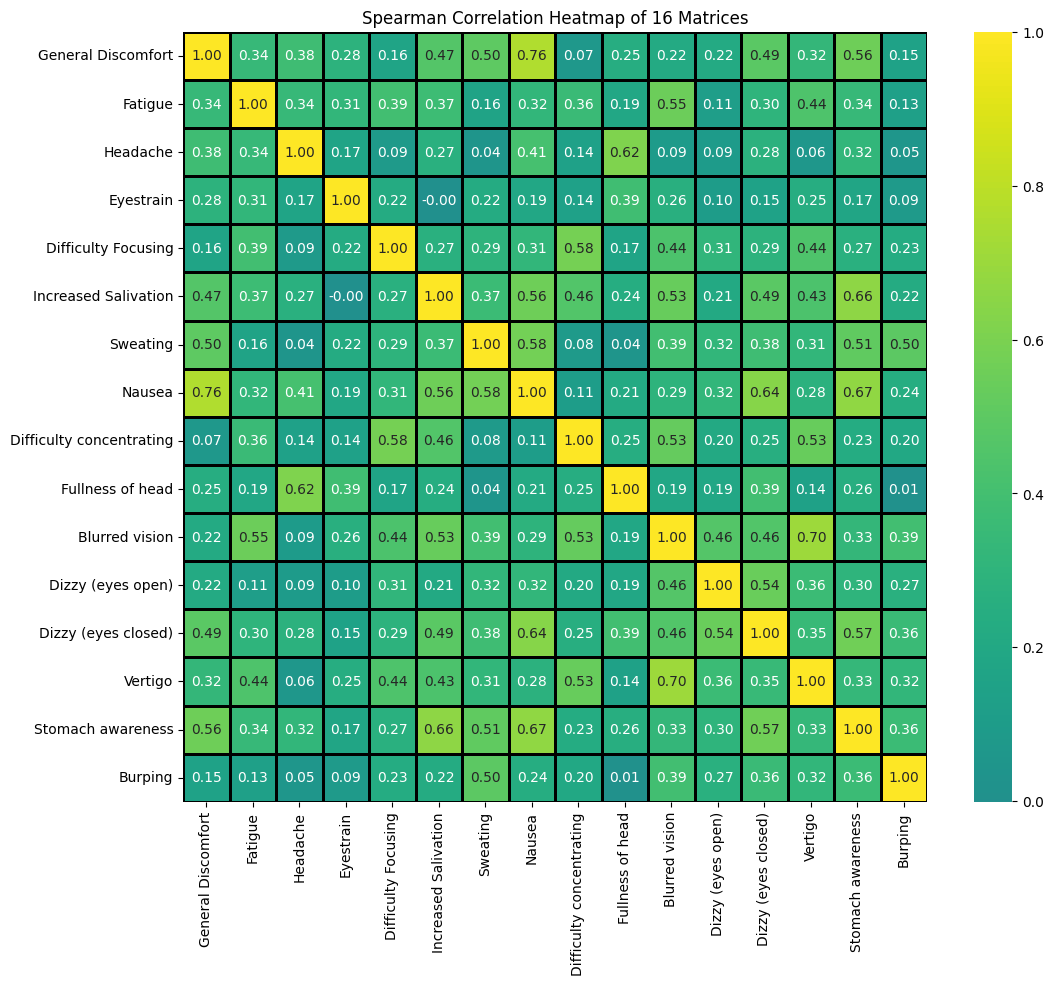

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


# Manually create column and index labels
variables = ["General Discomfort", "Fatigue", "Headache", "Eyestrain", "Difficulty Focusing", "Increased Salivation","Sweating",
              "Nausea", "Difficulty concentrating", "Fullness of head",  "Blurred vision", "Dizzy (eyes open)",
              "Dizzy (eyes closed)","Vertigo","Stomach awareness", "Burping"]

# Create a DataFrame from the correlation matrix
corr_df = pd.DataFrame(corr, columns=variables, index=variables)

# Plot the correlation matrix using seaborn heatmap with a chosen colormap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True,  fmt=".2f",cmap='viridis', center=0, linewidths=1, linecolor='black')

# Add titles and labels
plt.title("Spearman Correlation Heatmap of 16 Matrices")
plt.show()


In [15]:
def scale_input_data(input_train, input_test):
    # Get the shape of the input data
    num_samples_train, time_steps_train, num_features = input_train.shape
    num_samples_test, time_steps_test, _ = input_test.shape

    # Reshape the input data into 2D arrays
    flattened_train_data = input_train.reshape(-1, num_features)
    flattened_test_data = input_test.reshape(-1, num_features)

    # Initialize a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform both train and test data
    scaled_train_data = scaler.fit_transform(flattened_train_data)
    scaled_test_data = scaler.transform(flattened_test_data)

    # Reshape the scaled data back to its original shape
    scaled_train_data = scaled_train_data.reshape(num_samples_train, time_steps_train, num_features)
    scaled_test_data = scaled_test_data.reshape(num_samples_test, time_steps_test, num_features)

    return scaled_train_data, scaled_test_data

def scale_target_var(target_data):
    min_val, max_val = np.min(target_data, axis=0), np.max(target_data, axis=0)
    target_data = (target_data-min_val)/(max_val-min_val)

    return target_data, min_val, max_val

In [16]:
input_train, input_test= scale_input_data(input_train[:, (60-sample_size):(180-sample_size), :], input_test[:, (60-sample_size):(180-sample_size), :])
output_train, min_val, max_val = scale_target_var(output_train)

input_val = input_train[val_indices]
input_train = input_train[train_indices]
output_val = output_train_total_ssq[val_indices]
output_train = output_train[train_indices]


In [17]:
print("input_train :", input_train.shape)
print("output_train :", output_train.shape)
print("input_val :", input_val.shape)
print("output_val :", output_val.shape)
print("input_test :", input_test.shape)
print("output_test :", output_test.shape)

input_train : (36, 120, 47)
output_train : (36, 16)
input_val : (9, 120, 47)
output_val : (9, 1)
input_test : (23, 120, 47)
output_test : (23, 16)


In [18]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
import numpy as np
import sklearn

total_losses=[]
for iteration in range(5):
    def get_shared_lstm(input_shape1, input_shape2):
        # Define shared LSTM model
        input_layer = Input(shape=(input_shape1, input_shape2))
        x = LSTM(64, return_sequences=False)(input_layer)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        shared_model = Model(inputs=input_layer, outputs=x)
        return shared_model




    def get_output_model(shared_lstm_output, output_shape):
        # Define separate output model for each column
        output_models = []
        for i in range(output_shape[1]):
            output_model = Sequential()
            output_model.add(Dense(256, activation='relu'))
            output_model.add(Dropout(0.2))
            output_model.add(Dense(1))  # Output shape is (None, 1) for each column
            output_model_output = output_model(shared_lstm_output)
            output_models.append(output_model_output)
        return output_models

    # Assuming train_input, train_output, test_input, test_output are numpy arrays

    # Reshape train and test inputs to match LSTM input shape
    train_input_reshaped = input_train.reshape((input_train.shape[0], input_train.shape[1], input_train.shape[2]))
    test_input_reshaped = input_test.reshape((input_test.shape[0], input_test.shape[1], input_test.shape[2]))
    val_input_reshaped = input_val.reshape((input_val.shape[0], input_val.shape[1], input_val.shape[2]))
    # Get shared LSTM model
    shared_lstm = get_shared_lstm(input_train.shape[1], input_train.shape[2])

    # Create separate output models for each column
    output_models = get_output_model(shared_lstm.output, output_train.shape)

    # Create combined model
    model = Model(inputs=shared_lstm.input, outputs=output_models)

    # Compile and train the model
    model.compile(loss='mse', optimizer='adam', metrics=[['mse'] for _ in range(output_train.shape[1])])  # Using MSE as loss and metric
    best_val=1000000
    patience=0
    best_model = None

    for k in range(200):
      # Predict test data
      model.fit(train_input_reshaped, [output_train[:, i] for i in range(output_train.shape[1])], epochs=1, batch_size=32)
      pred_val = np.array(model.predict(val_input_reshaped))
      pred_val = np.transpose(pred_val.squeeze(), (1, 0))
      print("k:", k, "patience:", patience)
      # Evaluate the model
      losses = []
      for i in range(pred_val.shape[0]):
        total_ssq=0
        for j in [0,5,6,7,8,14,15]:
          total_ssq=np.sum(pred_val[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq

        for j in [0,1,2,3,4,8,10]:
          total_ssq=np.sum(pred_val[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq

        for j in [4,7,9,10,11,12,13]:
          total_ssq=np.sum(pred_val[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq
        total_ssq=total_ssq*3.74
        output_val_ssq= output_val[i,0]
        #print("total_ssq",total_ssq)
        #print("output_val_ssq",output_val_ssq)
        loss = sklearn.metrics.mean_squared_error([total_ssq], [output_val_ssq], squared=False)
        losses.append(loss)
      tmp_val_loss = np.mean(losses)
      if tmp_val_loss <= best_val:
          best_val = tmp_val_loss
          patience = 0
          best_model = model
      else:
          patience +=1
          if patience > 10:
            break

    # Predict test data
    pred_test = np.array(best_model.predict(test_input_reshaped))
    pred_test = np.transpose(pred_test.squeeze(), (1, 0))
    # Evaluate the model
    pred_total_ssq = []
    #losses=[]
    for i in range(pred_test.shape[0]):
        total_ssq=0
        for j in [0,5,6,7,8,14,15]:
          total_ssq=np.sum(pred_test[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq

        for j in [0,1,2,3,4,8,10]:
          total_ssq=np.sum(pred_test[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq

        for j in [4,7,9,10,11,12,13]:
          total_ssq=np.sum(pred_test[i,j]*(max_val[j]-min_val[j]) + min_val[j])+total_ssq
        total_ssq=total_ssq*3.74

        pred_total_ssq.append(total_ssq)


    # Overall Test Loss
    loss = sklearn.metrics.mean_squared_error(pred_total_ssq, output_test_total_ssq, squared = False)
    print("Test Loss no ",iteration,":" ,loss)
    total_losses.append(loss)
average_loss = sum(total_losses) / len(total_losses)

print(sample_size, simulations_test)
print("average_loss:",average_loss)


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 1.3680 - sequential_10_mse: 0.0480 - sequential_11_mse: 0.0985 - sequential_12_mse: 0.0469 - sequential_13_mse: 0.0362 - sequential_14_mse: 0.2504 - sequential_15_mse: 0.0620 - sequential_1_mse: 0.0728 - sequential_2_mse: 0.0545 - sequential_3_mse: 0.1746 - sequential_4_mse: 0.0326 - sequential_5_mse: 0.0520 - sequential_6_mse: 0.1449 - sequential_7_mse: 0.1003 - sequential_8_mse: 0.0259 - sequential_9_mse: 0.0780 - sequential_mse: 0.0904
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
k: 0 patience: 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.9459 - sequential_10_mse: 0.0280 - sequential_11_mse: 0.0949 - sequential_12_mse: 0.0473 - sequential_13_mse: 0.0259 - sequential_14_mse: 0.0709 - sequential_15_mse: 0.0560 - sequential_1_mse: 0.0636 - sequential_2_mse: 0.0642 - sequential_3_mse: 0.0720 - sequential_4_mse: 0.0350 - sequential_5_mse: 0.0472 - sequential_6_mse: 0.0895 - sequential_7_mse: 0.0630 - sequential_8_mse: 0.0218 - sequential_9_m